In [9]:
import numpy as np
from matplotlib import pyplot as plt

import kwant
kwant.__version__

'1.4.0'

In [10]:
s0 = np.array([[1, 0], [0, 1]])
sx = np.array([[0, 1], [1, 0]])
sy = np.array([[0, -1j], [1j, 0]])
sz = np.array([[1, 0], [0, -1]])

# Simple square lattice

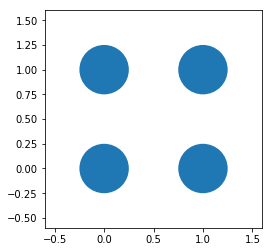

In [15]:
a = 1 # Set lattice constant
lat = kwant.lattice.square(a) # Create a lattice 
syst = kwant.Builder() # Create a tight-binding system

# Specify onsite energies
syst[lat(0, 0)] = 2
syst[lat(1, 0)] = 2
syst[lat(0, 1)] = 2
syst[lat(1, 1)] = 2

# Plot the system
fig = kwant.plot(syst);
fig.savefig("example-1.png", dpi=196);

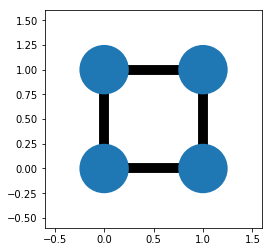

In [16]:
syst[lat.neighbors()] = -1
kwant.plot(syst);

# Two monatomic lattices

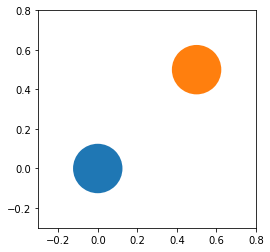

In [17]:
primitive_vectors = [(1, 0), (0, 1)]
lat_a = kwant.lattice.Monatomic(primitive_vectors, offset=(0, 0))
lat_b = kwant.lattice.Monatomic(primitive_vectors, offset=(0.5, 0.5))

# lat1 is equivalent to kwant.lattice.square()
syst = kwant.Builder()

# Onsite matrix elements can be even matrices:
syst[lat_a(0, 0)] = 4*sx
syst[lat_b(0, 0)] = 4*sy + 3*sy.conj().T

kwant.plot(syst);

# One polyatomic lattice containing two sublattices

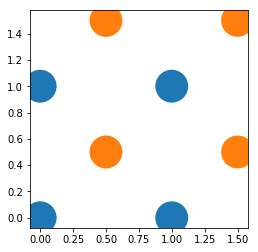

In [18]:
# https://kwant-project.org/doc/1/reference/generated/kwant.lattice.Polyatomic#kwant.lattice.Polyatomic
lat = kwant.lattice.Polyatomic(prim_vecs=[(1, 0), (0, 1)], # The primitive vectors of the Bravais lattice
                               basis=[(0, 0), (0.5, 0.5)]) # The coordinates of the basis sites inside the unit cell.

sub_a, sub_b = lat.sublattices

syst = kwant.Builder()

syst[sub_a(1,1)] = 4
syst[sub_a(0,0)] = 4
syst[sub_a(1,0)] = 4
syst[sub_a(0,1)] = 4

syst[sub_b(0,0)] = 4
syst[sub_b(0,1)] = 4
syst[sub_b(1,0)] = 4
syst[sub_b(1,1)] = 4

kwant.plot(syst);

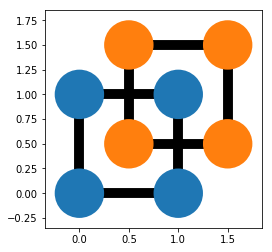

In [19]:
syst[sub_a.neighbors()] = -1
syst[sub_b.neighbors()] = -1

kwant.plot(syst);

# 1 dimensional lattice

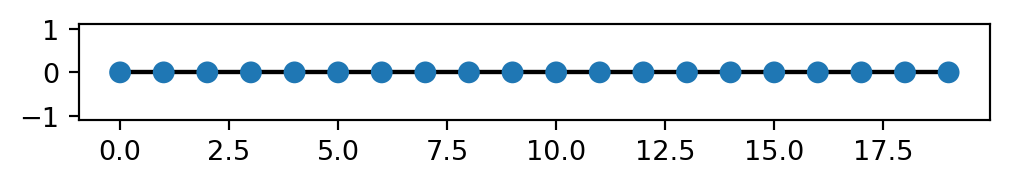

In [20]:
def create_chain(a=1, n=20, hoppings=False):
  lat = kwant.lattice.chain(a)
  
  syst = kwant.Builder()
  
  for j in range(20):
    syst[lat(j)] = 4
    
  if hoppings:
    syst[lat.neighbors()] = -1
  
  return lat, syst

lat, sys = create_chain(1,20, True)
kwant.plot(sys, dpi=196);

# Solving eigenvalues for a closed system

In [21]:
# Get the hamiltonian matrix of the system
ham_mat = syst.finalized().hamiltonian_submatrix(sparse=True)

# Use scipy to solve the eigenvalue problem
import scipy.sparse.linalg as sla

# The 15 lowest eigenvalues
ev = sla.eigsh(ham_mat.tocsc(), k=5, return_eigenvectors=False)

In [22]:
ev

array([4., 4., 4., 6., 6.])

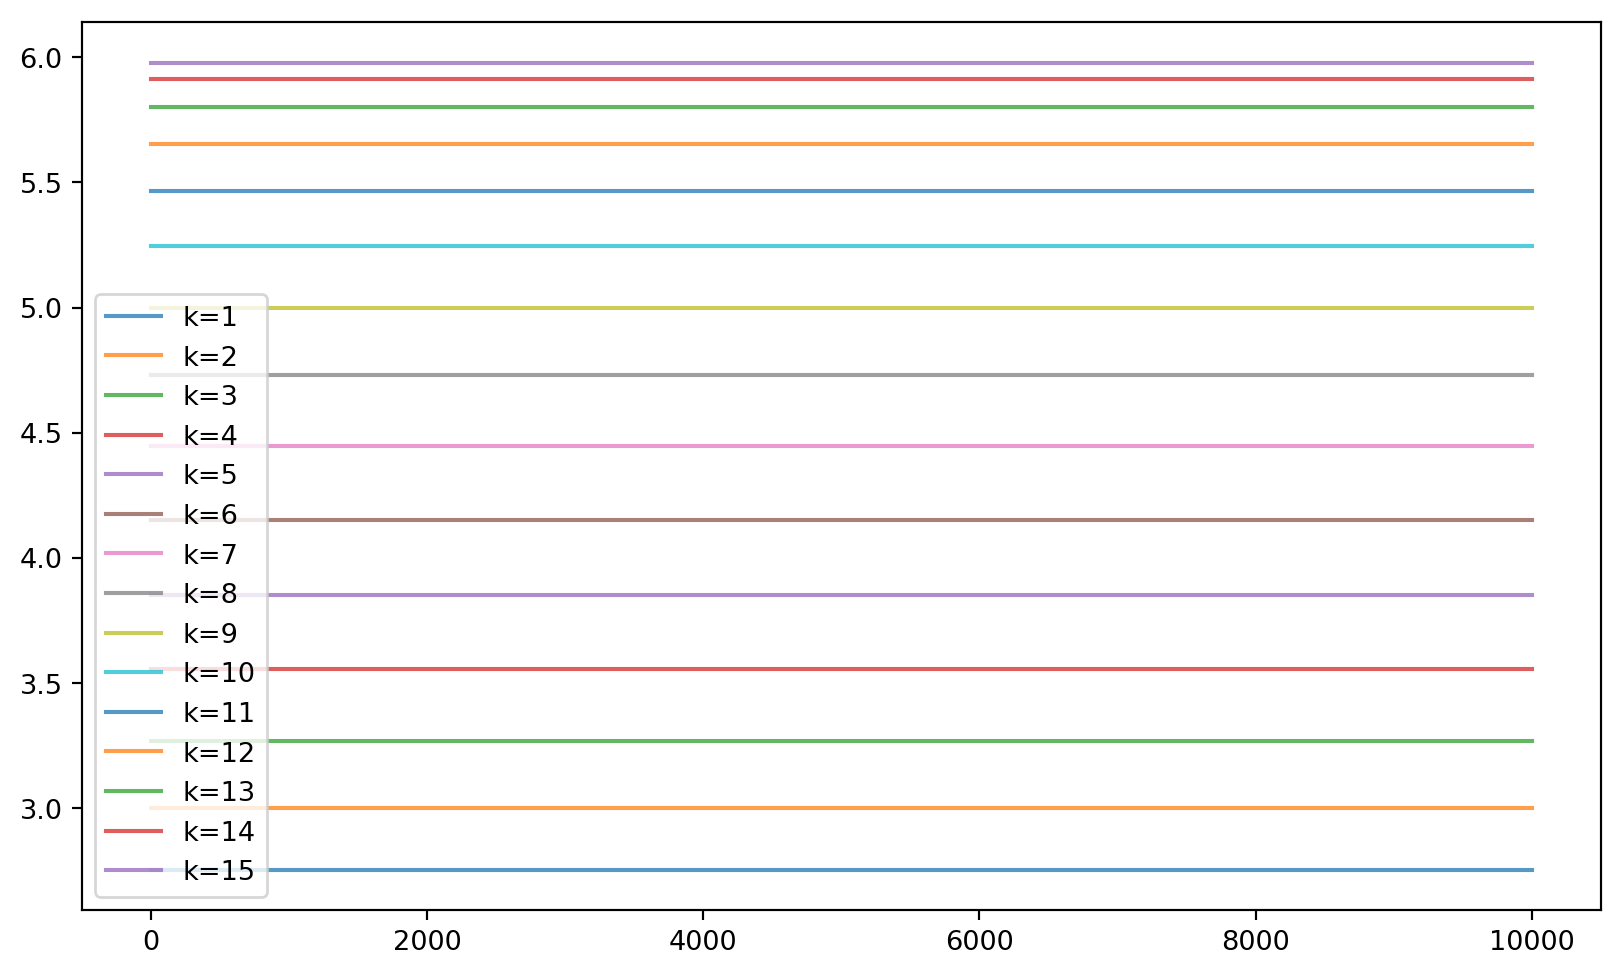

In [23]:
# Use scipy to solve the eigenvalue problem
import scipy.sparse.linalg as sla

def eigv_plotter():
  
  aa = np.linspace(0.01, 10000, 1000)
  evs = []
  
  n_eig = 15 # The number of lowest eigenvalues
  
  for a in aa:
    lat, sys = create_chain(a, 2, True)
    ham_mat = sys.finalized().hamiltonian_submatrix(sparse=True)
    
    
    ev = sla.eigsh(ham_mat.tocsc(), k=n_eig, return_eigenvectors=False)
    evs.append(ev)
    
  evs = np.array(evs)
  
  plt.figure(figsize=(10, 6), dpi=196)
  
  for j in range(n_eig):
    plt.plot(aa, evs.T[j, :], '-', alpha=.75, label="k={}".format(j+1))
    
  plt.legend()
  
  
eigv_plotter()

# Attaching leads to a system

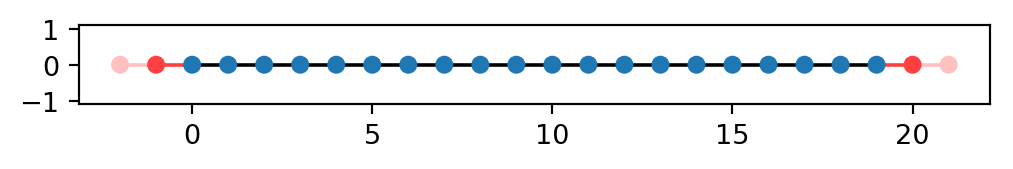

In [24]:
# Left lead
sleft = kwant.TranslationalSymmetry((-1,))
left_lead = kwant.Builder(sleft)

for j in range(5):
  left_lead[lat(j)] = 4

left_lead[lat.neighbors()] = -1
sys.attach_lead(left_lead)

# Right lead
sright = kwant.TranslationalSymmetry((1,))
right_lead = kwant.Builder(sright)

for j in range(5):
  right_lead[lat(20+j)] = 4
  
right_lead[lat.neighbors()] = -1
sys.attach_lead(right_lead)

kwant.plot(sys, dpi=196);

# Creating a square lattice with circle shape

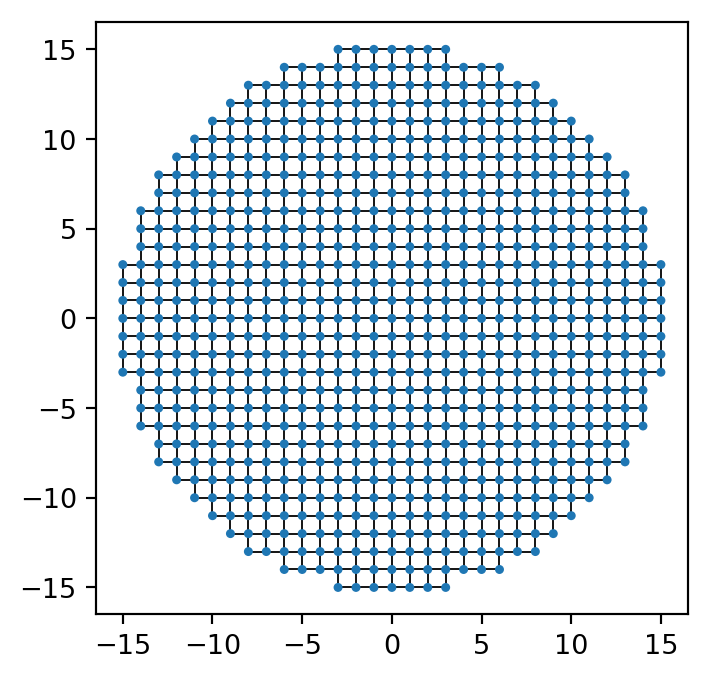

In [28]:
a = 1 # Set lattice constant
lat = kwant.lattice.square(a) # Create a lattice 
syst = kwant.Builder() # Create a tight-binding system

# A shape can be defined using a function, that returns True, if a point is
# inside the shape, False otherwise
def circle(pos):
  x,y = pos
  return x**2 + y**2 < 240

# Fill the shape
syst[lat.shape(function=circle, start=(0,0))] = 4

# Adding hoppings to the lattice:
syst[lat.neighbors()] = t

fig = kwant.plot(syst, dpi=196);
fig.savefig("circular_square_lat.png", dpi=196)

/Users/nagydaniel/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: The plotted data contains 1.15% of values overflowing upper limit 0.0088008 
  del sys.path[0]
/Users/nagydaniel/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: The plotted data contains 1.28% of values overflowing upper limit 0.00800326 
  del sys.path[0]


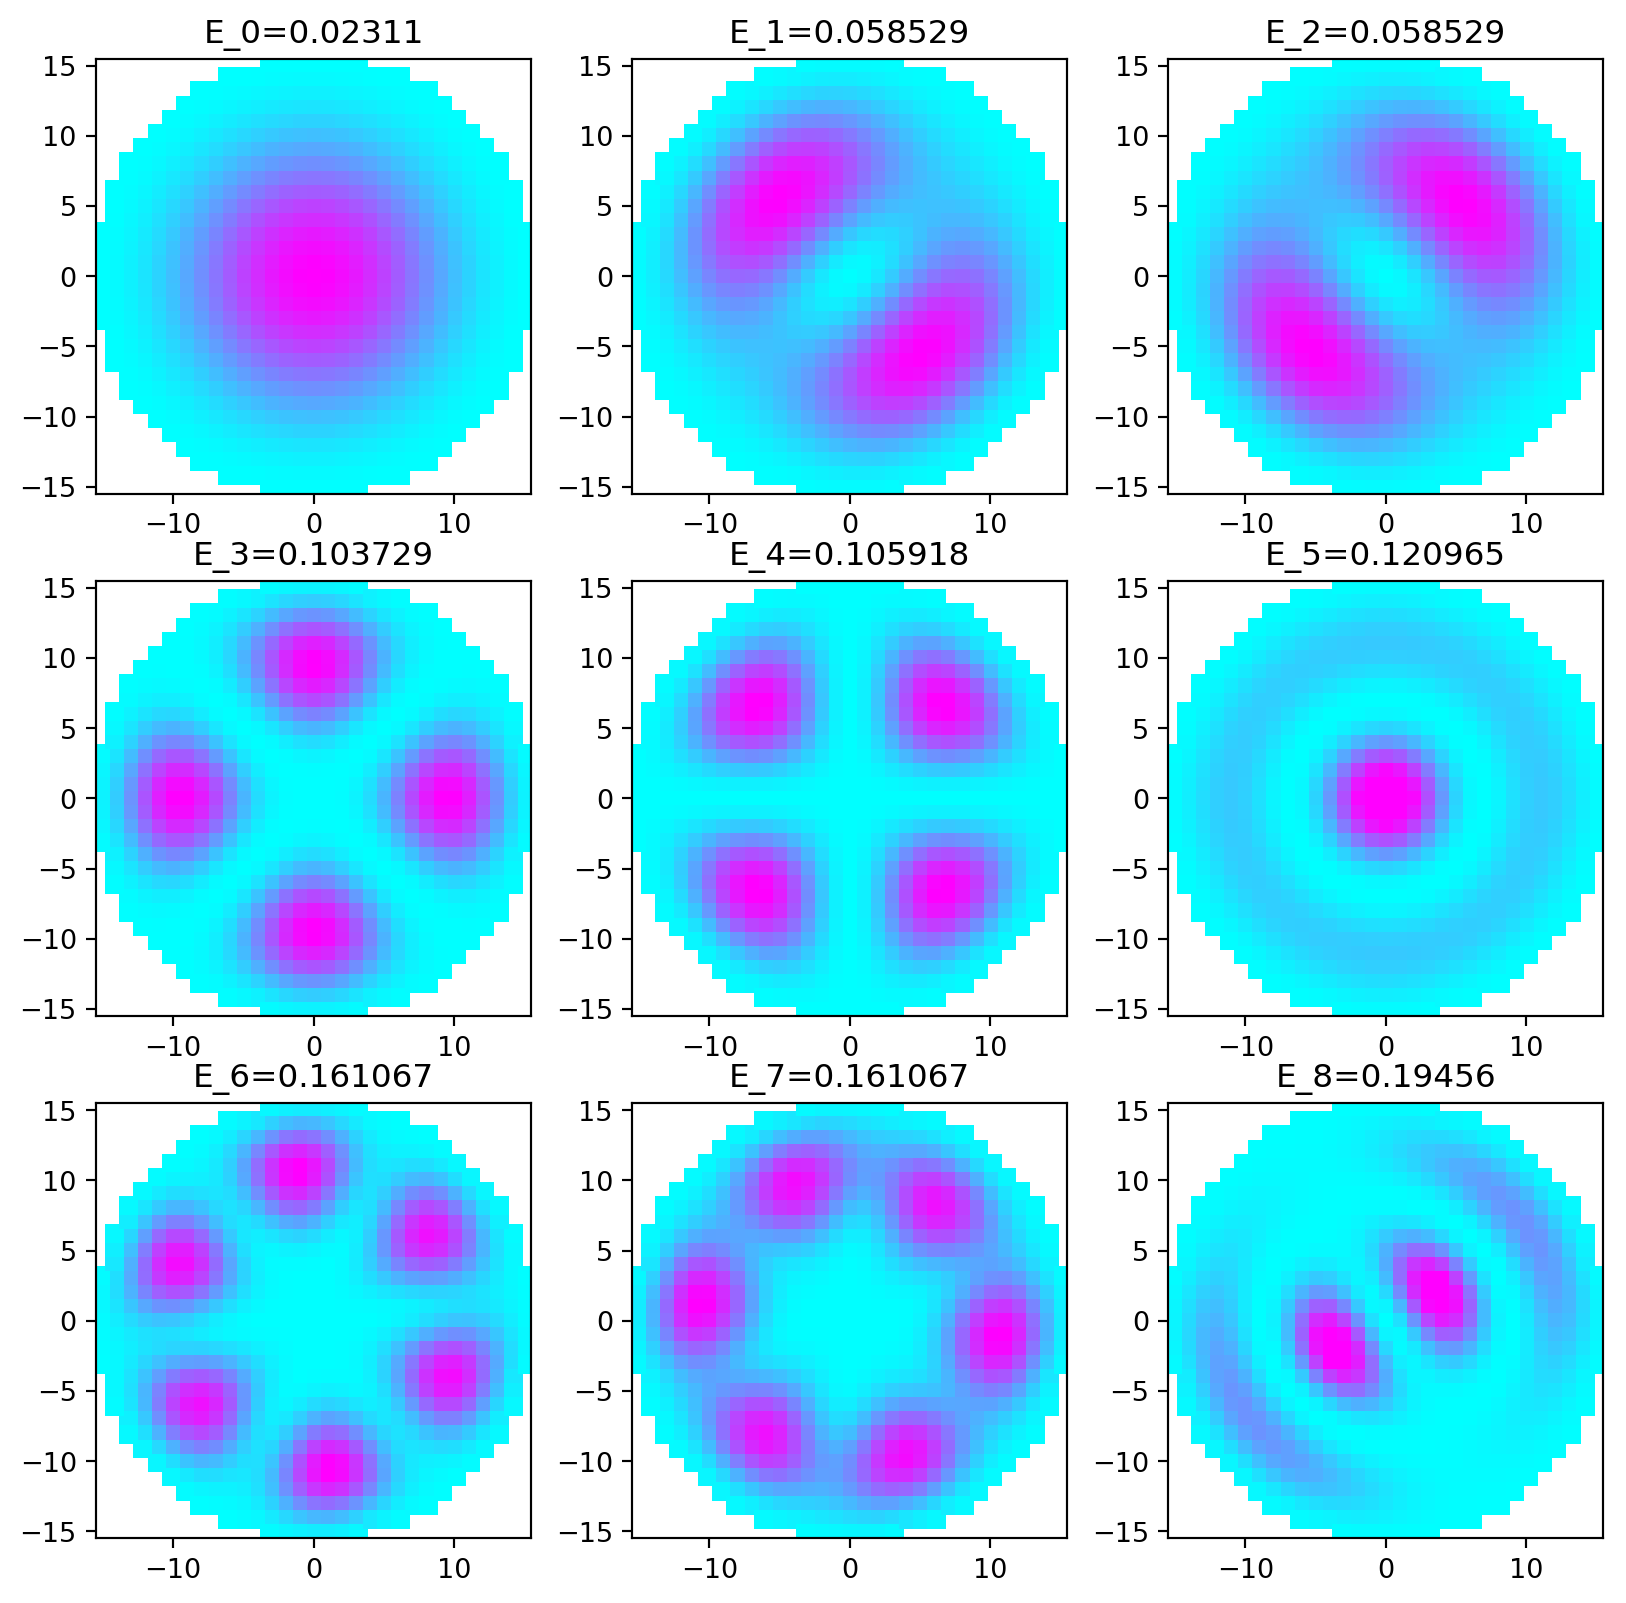

In [31]:
# Get the Hamiltonian
ham_mat = syst.finalized().hamiltonian_submatrix(sparse=True)

# Calculate eigenfunctions using scipy
evals, evecs = sla.eigsh(ham_mat.tocsc(), k=9, sigma=0)

# Plot the eigenfunctions using kwant.plotter.map
fig, axes = plt.subplots(3, 3, figsize=(10, 10), dpi=196)
for i in range(9):
  kwant.plotter.map(syst.finalized(), 
                    np.abs(evecs[:, i])**2, 
                    cmap='cool', background='w',
                    ax=axes[int(i/3)][i%3])
  axes[int(i/3)][i%3].set_title("E_{0}={1}".format(i, np.round(evals[i],6)))
  
fig.savefig("circular_square_lat_eigvs.png", dpi=196)

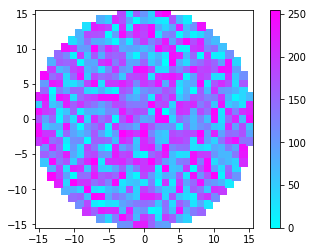

In [32]:
kwant.plotter.map(syst.finalized(), np.random.randint(0,255, size=(749,)), cmap='cool', background='w');

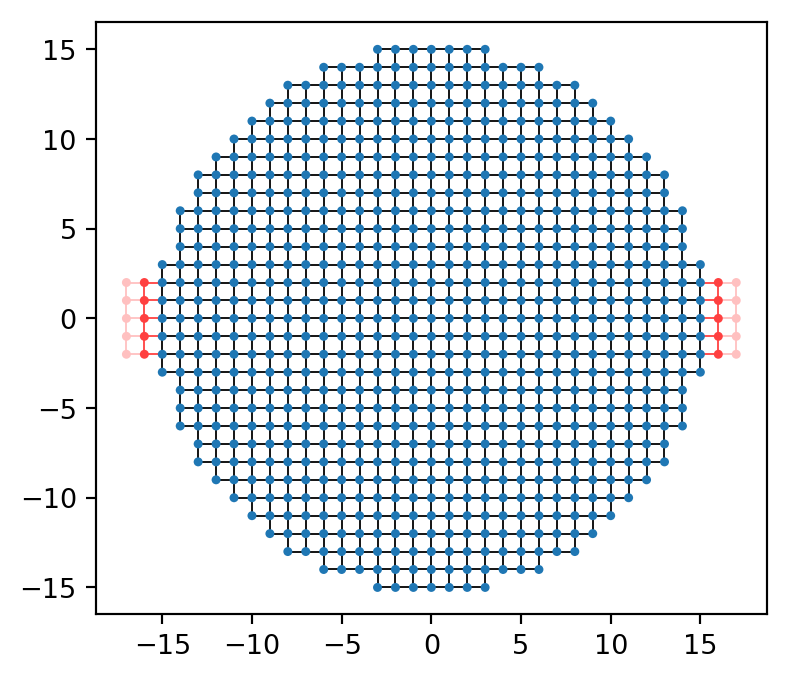

In [33]:
lead_W = 6.0

def lead_shape(pos):
  x,y = pos
  return (-lead_W/2 < y < lead_W/2)

lead_sym = kwant.TranslationalSymmetry((-a, 0))
lead = kwant.Builder(lead_sym)

lead[lat.shape(lead_shape, (0,0))] = 4
lead[lat.neighbors()] = -1

syst.attach_lead(lead)
syst.attach_lead(lead.reversed())

fig = kwant.plot(syst, dpi=196);
fig.savefig("circular_sq_lat_wleads.png", dpi=196)

# Calculating local density of states

/Users/nagydaniel/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: The plotted data contains 1.02% of values overflowing upper limit 0.0773557 
  


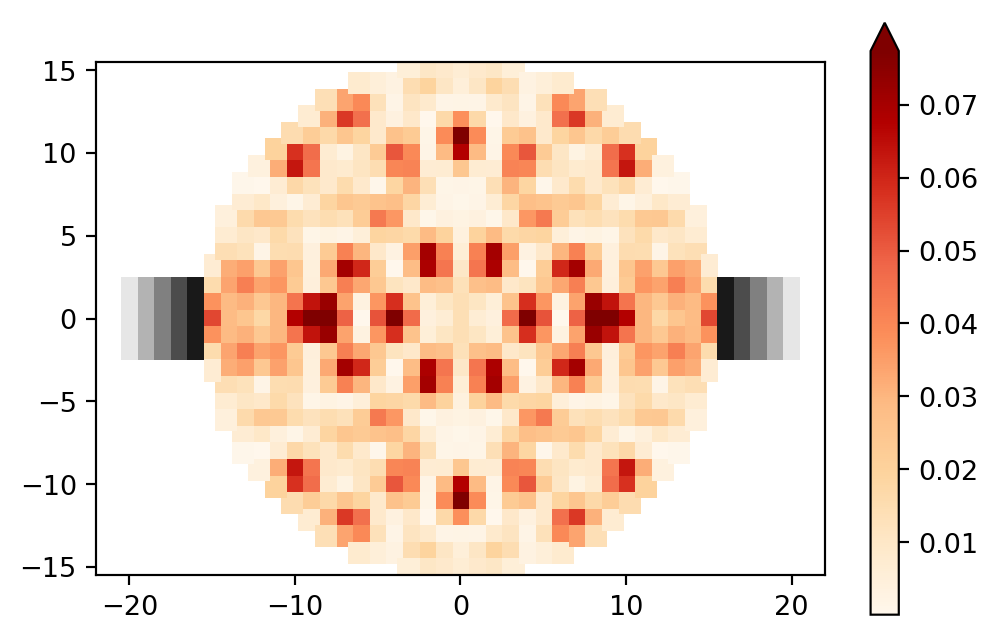

In [34]:
local_dos = kwant.ldos(syst.finalized(), energy=1.0)
fig = kwant.plotter.map(syst.finalized(), local_dos, 
                  num_lead_cells=5,
                  background='w',
                  cmap='OrRd',
                  dpi=196);
fig.savefig("circular_square_lat_ldos.png", dpi=196)

# Point contact (constriction)

In [ ]:
a = 1
lat = kwant.lattice.square(a)
syst = kwant.Builder()

t = -2.0
V_L = -3*t
V_S = -3*t

w_constriction = 8
l_constriction = 10

w_lead = 40
l_lead = 3

# A shape can be defined using a function, that returns True, if a point is
# inside the shape, False otherwise
def shape1(pos):
  x,y = pos
  return abs(x) < l_constriction and abs(y) < w_constriction

def shape2(pos):
  x,y = pos
  return (l_constriction <= abs(x) < l_constriction + l_lead) and abs(y) < w_lead 

# Doc: https://kwant-project.org/doc/1/reference/generated/kwant.lattice.Polyatomic#kwant.lattice.Polyatomic.shape
syst[lat.shape(function=shape1, start=(0,0))] = V_S
syst[lat.shape(function=shape2, start=(l_constriction,0))] = V_S
syst[lat.shape(function=shape2, start=(-l_constriction,0))] = V_S

# Adding hoppings to the lattice:
syst[lat.neighbors()] = t

# Attach leads to the system
def lead_shape(pos):
  x,y = pos
  return (-w_lead < y < w_lead)

lead_sym = kwant.TranslationalSymmetry((-a, 0))
lead = kwant.Builder(lead_sym)

lead[lat.shape(lead_shape, (0,0))] = V_L
lead[lat.neighbors()] = t

syst.attach_lead(lead)
syst.attach_lead(lead.reversed())

fig = kwant.plot(syst, dpi=196);
fig.savefig("2degconst_W{0}_L{1}.png".format(w_constriction, l_constriction), dpi=196)

In [ ]:
energies = np.linspace(0, 5, 150)
data = []

syst = syst.finalized()

sn_data = []

for e in energies:
  # compute the scattering matrix at a given energy
  smatrix = kwant.smatrix(syst, e)
  
  # compute the transmission probability from lead 0 to
  # lead 1
  data.append(smatrix.transmission(1, 0))
  
  # Calculating two-terminal shotnoise for the same system
  sn_data.append(kwant.physics.two_terminal_shotnoise(smatrix))

In [ ]:
# We should see conductance steps
plt.figure(dpi=196)
plt.plot(energies, data, "-")
plt.xlabel("E [t]")
plt.title(r"$V_L={0}, V_S={1}, t={2}$".format(V_L, V_S, t))
plt.ylabel(r"$\sigma$ [$2e^2/h$]")
plt.savefig("cond_2deg_W{0}_L{1}_VL{2}_VS{3}.png".format(w_constriction, l_constriction, V_L, V_S), dpi=196)

In [ ]:
plt.figure(dpi=196)
plt.plot(energies, sn_data, "-")
plt.xlabel("E [t]")
plt.title(r"$V_L={0}, V_S={1}, t={2}$".format(V_L, V_S, t))
plt.ylabel(r"shotnoise [$2e^3|V|/(\pi\hbar)$]")
plt.savefig("shotnoise_2deg_W{0}_L{1}_VL{2}_VS{3}.png".format(w_constriction, l_constriction, V_L, V_S), dpi=196)

In [ ]:
# Mu-dependence of conductance using kernel polynomial method
sigma_xy = kwant.kpm.conductivity(syst, alpha='x', beta='y')
conductivities = [sigma_xy(mu=mu, temperature=0.1) for mu in np.linspace(0, 4)]

In [ ]:
help(kwant.kpm)